In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as img
import panel as pn
import itertools
import math
import param
import fsspec

pn.extension()

In [2]:
image_bucket = "ncar-cesm-pop-test/images"
fs = fsspec.filesystem("s3", anon=True)

In [3]:
files = fs.glob(f"{image_bucket}/*/*.png")
len(files)

2338

In [4]:
def parse_file(file):
    path = file
    file = Path(file)
    x = dict(path=path)
    if "checkpoint" in path:
        return {}
    plot_type = file.parent.stem
    x["plot_type"] = plot_type
    parts = file.stem.split("+")
    x["varname"] = parts[0]
    if plot_type == "timestep-global-map":
        x["plot_type"] = plot_type
        x["time"] = parts[1]
    if len(parts) > 2:
        if plot_type == "global-timeseries":
            idx = 1
        else:
            idx = 2
        for part in parts[idx:]:
            y = part.split("@")
            x[y[0]] = y[1]
            if y[0].startswith("z_t"):
                x["depth_level"] = y[1]
    return x


entries = [parse_file(file) for file in files]

In [5]:
df = pd.DataFrame(entries).dropna(subset=["path"])

df["z_t"] = df["z_t"].astype(float)
df["z_t_150m"] = df["z_t_150m"].astype(float)
df["depth_level"] = df["depth_level"].astype(float)
df["depth_level"] = df["depth_level"].fillna(-9999)
df["log_10"] = df.log_10.map(lambda x: True if x == "True" else False)
df.head()

path          plot_type  \
0  ncar-cesm-pop-test/images/global-timeseries/Ca...  global-timeseries   
1  ncar-cesm-pop-test/images/global-timeseries/Dp...  global-timeseries   
2  ncar-cesm-pop-test/images/global-timeseries/FG...  global-timeseries   
3  ncar-cesm-pop-test/images/global-timeseries/NH...  global-timeseries   
4  ncar-cesm-pop-test/images/global-timeseries/NH...  global-timeseries   

            varname spatial_op time_coarsen_len    z_t  depth_level  z_t_150m  \
0   CaCO3_FLUX_100m  integrate               12    NaN      -9999.0       NaN   
1             DpCO2    average               12    NaN      -9999.0       NaN   
2            FG_CO2  integrate               12    NaN      -9999.0       NaN   
3               NH4    average               12  500.0        500.0       NaN   
4  NHx_SURFACE_EMIS  integrate               12    NaN      -9999.0       NaN   

  time  log_10  
0  NaN   False  
1  NaN   False  
2  NaN   False  
3  NaN   False  
4  NaN   False

In [6]:
groups = {}
grouped = df.groupby("plot_type")
for key in grouped.groups:
    groups[key] = grouped.get_group(key)
groups.keys()

dict_keys(['global-timeseries', 'timestep-global-map'])

In [17]:
class BaseDashboard(param.Parameterized):
    def __init__(self, **params):
        super().__init__(**params)
        self.update_data()

    def get_data(self):
        raise NotImplementedError()

    def update_data(self):
        raise NotImplementedError()

    def plot(self):
        nrows, ncols = 1, 1
        fig, ax = plt.subplots(
            nrows=nrows, ncols=ncols, figsize=(8.5, 6.5), squeeze=True
        )
        try:
            df = self.get_data()
            path = df.iloc[0].path
            with fs.open(path) as f:
                data = img.imread(f)
            ax.imshow(data)

        except Exception:
            pass

        ax.axis("off")
        plt.tight_layout()
        plt.close(fig)
        return fig


class TimestepDashboard(BaseDashboard):
    title = "## Time Slice Map"

    _df = df[(df.plot_type == "timestep-global-map")]
    variable = param.ObjectSelector(
        default="CaCO3_FLUX_100m", objects=sorted(_df.varname.unique())
    )
    depth_level = param.ObjectSelector(
        default=-9999, objects=sorted(_df.depth_level.unique().tolist())
    )
    apply_log10 = param.Selector(default=False, objects=[False, True])
    data = param.Parameter(default=None, precedence=-1)
    times = param.Parameter(default=None, precedence=-1)
    time = param.Integer()

    def get_data(self):
        df = self.data[
            (self.data.time == self.times[self.time])
            & (self.data.depth_level == self.depth_level)
            & (self.data.log_10 == self.apply_log10)
        ]
        return df

    @param.depends("variable", "time", watch=True)
    def update_data(self):
        self.data = self._df[(self._df.varname == self.variable)]
        self.param.depth_level.objects = sorted(self.data.depth_level.unique())
        self.depth_level = self.param.depth_level.objects[0]
        self.times = sorted(self.data.time.unique())
        self.param.time.bounds = (0, len(self.times) - 1)
        self.param.apply_log10.objects = sorted(self.data.log_10.unique())
        self.apply_log10 = self.param.apply_log10.objects[0]


dd_left = TimestepDashboard(name="")
dd_right = TimestepDashboard(name="", variable="O2_ZMIN_DEPTH")

one_timestep_dashboard = pn.Column(
    dd_left.title,
    pn.Row(
        pn.Column(pn.WidgetBox(pn.Row(dd_left.param), pn.Row(dd_left.plot))),
        pn.Column(pn.WidgetBox(pn.Row(dd_right.param), pn.Row(dd_right.plot))),
    ),
)

In [18]:
class TimeseriesDashboard(BaseDashboard):
    title = "## Timeseries Plot"
    _df = df[(df.plot_type == "global-timeseries")]

    variable = param.ObjectSelector(
        default="CaCO3_FLUX_100m", objects=sorted(_df.varname.unique())
    )
    depth_level = param.ObjectSelector(
        default=-9999, objects=sorted(_df.depth_level.unique())
    )
    spatial_operation = param.Selector(objects=sorted(_df.spatial_op.unique()))
    time_coarsen_length = param.Selector(
        objects=sorted(_df.time_coarsen_len.unique())
    )

    data = param.Parameter(default=None, precedence=-1)

    def get_data(self):
        df = self.data[
            (self.data.spatial_op == self.spatial_operation)
            & (self.data.depth_level == self.depth_level)
            & (self.data.time_coarsen_len == self.time_coarsen_length)
        ]
        return df

    @param.depends("variable", watch=True)
    def update_data(self):
        self.data = self._df[(self._df.varname == self.variable)]
        self.param.spatial_operation.objects = sorted(
            self.data.spatial_op.unique()
        )
        self.spatial_operation = self.param.spatial_operation.objects[0]
        self.param.depth_level.objects = sorted(self.data.depth_level.unique())
        self.depth_level = self.param.depth_level.objects[0]
        self.param.time_coarsen_length.objects = sorted(
            self.data.time_coarsen_len.unique()
        )
        self.time_coarsen_length = self.param.time_coarsen_length.objects[0]


td_left = TimeseriesDashboard(name="", variable="O2_ZMIN")
td_right = TimeseriesDashboard(name="", variable="O2_ZMIN_DEPTH")
timeseries_dashboard = pn.Column(
    td_left.title,
    pn.Row(
        pn.Column(pn.WidgetBox(pn.Row(td_left.param), pn.Row(td_left.plot))),
        pn.Column(pn.WidgetBox(pn.Row(td_right.param), pn.Row(td_right.plot))),
    ),
)

Tabs
    [0] Column
        [0] Markdown(str)
        [1] Row
            [0] Column
                [0] WidgetBox
                    [0] Row
                        [0] Column(margin=5, width=300)
                            [0] StaticText(value='<b></b>')
                            [1] Select(name='Variable', options=OrderedDict([('CaCO3_FLUX_...]), value='CaCO3_FLUX_100m')
                            [2] Select(name='Depth level', options=OrderedDict([('-9999.0', ...]), value=-9999.0)
                            [3] Select(name='Apply log10', options=OrderedDict([('False', ...]), value=False)
                            [4] IntSlider(end=59, name='Time')
                    [1] Row
                        [0] ParamMethod(method)
            [1] Column
                [0] WidgetBox
                    [0] Row
                        [0] Column(margin=5, width=300)
                            [0] StaticText(value='<b></b>')
                            [1] Select(name='Variable', options=OrderedDict([('CaCO3_FLUX_...]), value='O2_ZMIN_DEPTH')
                            [2] Select(name='Depth level', options=OrderedDict([('-9999.0', ...]), value=-9999.0)
                            [3] Select(name='Apply log10', options=OrderedDict([('False', ...]), value=False)
                            [4] IntSlider(end=59, name='Time')
                    [1] Row
                        [0] ParamMethod(method)
    [1] Column
        [0] Markdown(str)
        [1] Row
            [0] Column
                [0] WidgetBox
                    [0] Row
                        [0] Column(margin=5, width=300)
                            [0] StaticText(value='<b></b>')
                            [1] Select(name='Variable', options=OrderedDict([('CaCO3_FLUX_...]), value='O2_ZMIN')
                            [2] Select(name='Depth level', options=OrderedDict([('-9999.0', ...]), value=-9999.0)
                            [3] Select(name='Spatial operation', options=OrderedDict([('average', ...]), value='average')
                            [4] Select(name='Time coarsen length', options=OrderedDict([('12', ...]), value='12')
                    [1] Row
                        [0] ParamMethod(method)
            [1] Column
                [0] WidgetBox
                    [0] Row
                        [0] Column(margin=5, width=300)
                            [0] StaticText(value='<b></b>')
                            [1] Select(name='Variable', options=OrderedDict([('CaCO3_FLUX_...]), value='O2_ZMIN_DEPTH')
                            [2] Select(name='Depth level', options=OrderedDict([('-9999.0', ...]), value=-9999.0)
                            [3] Select(name='Spatial operation', options=OrderedDict([('average', ...]), value='average')
                            [4] Select(name='Time coarsen length', options=OrderedDict([('12', ...]), value='12')
                    [1] Row
                        [0] ParamMethod(method)
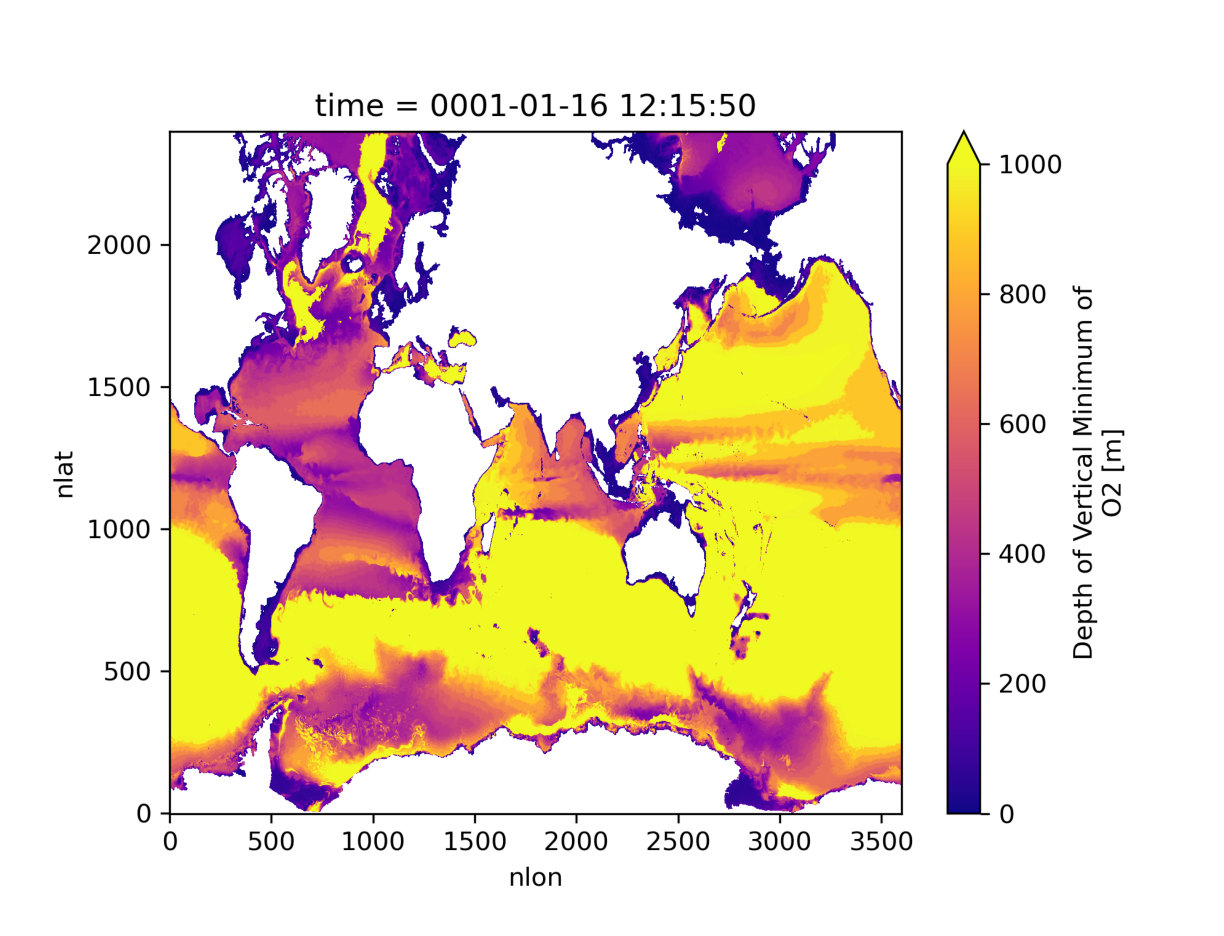
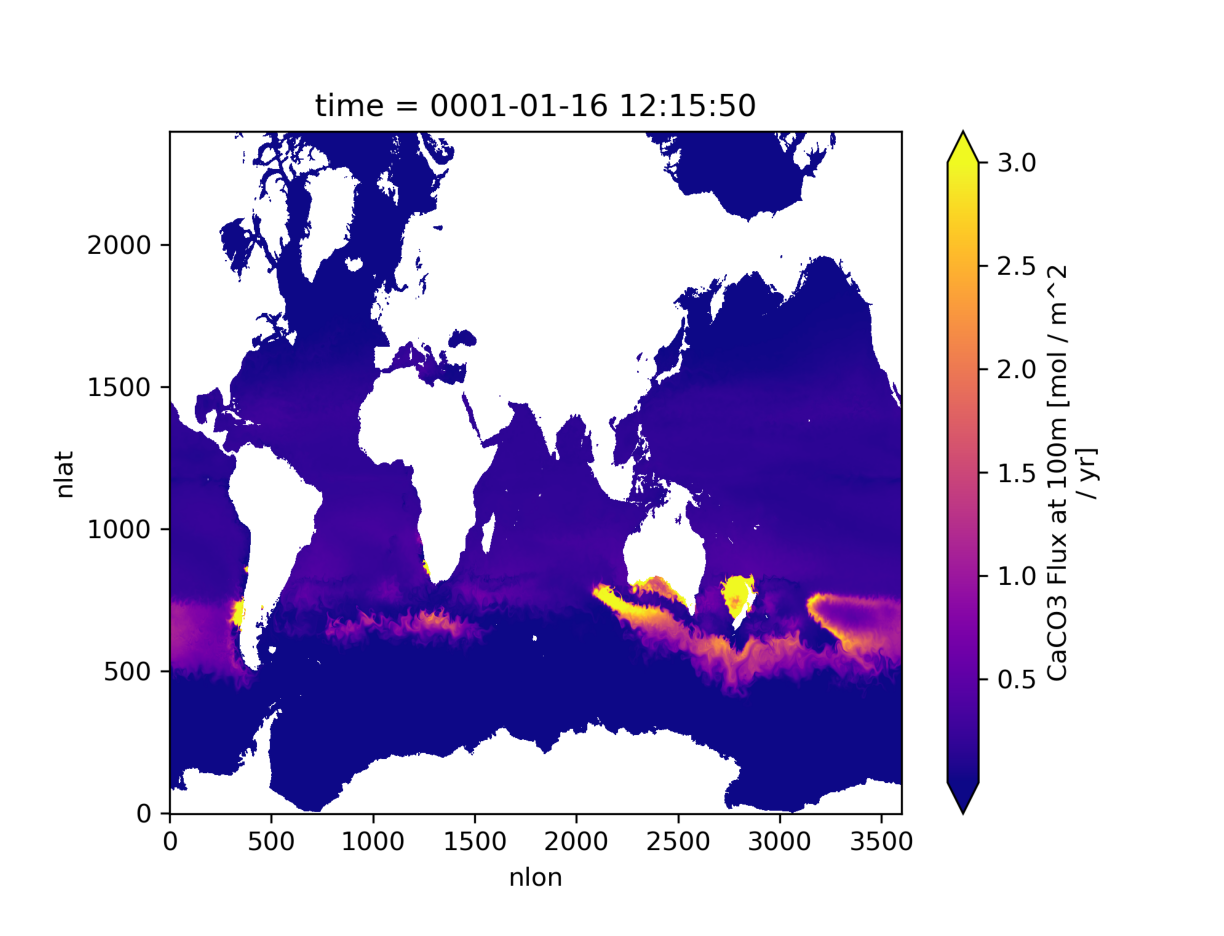
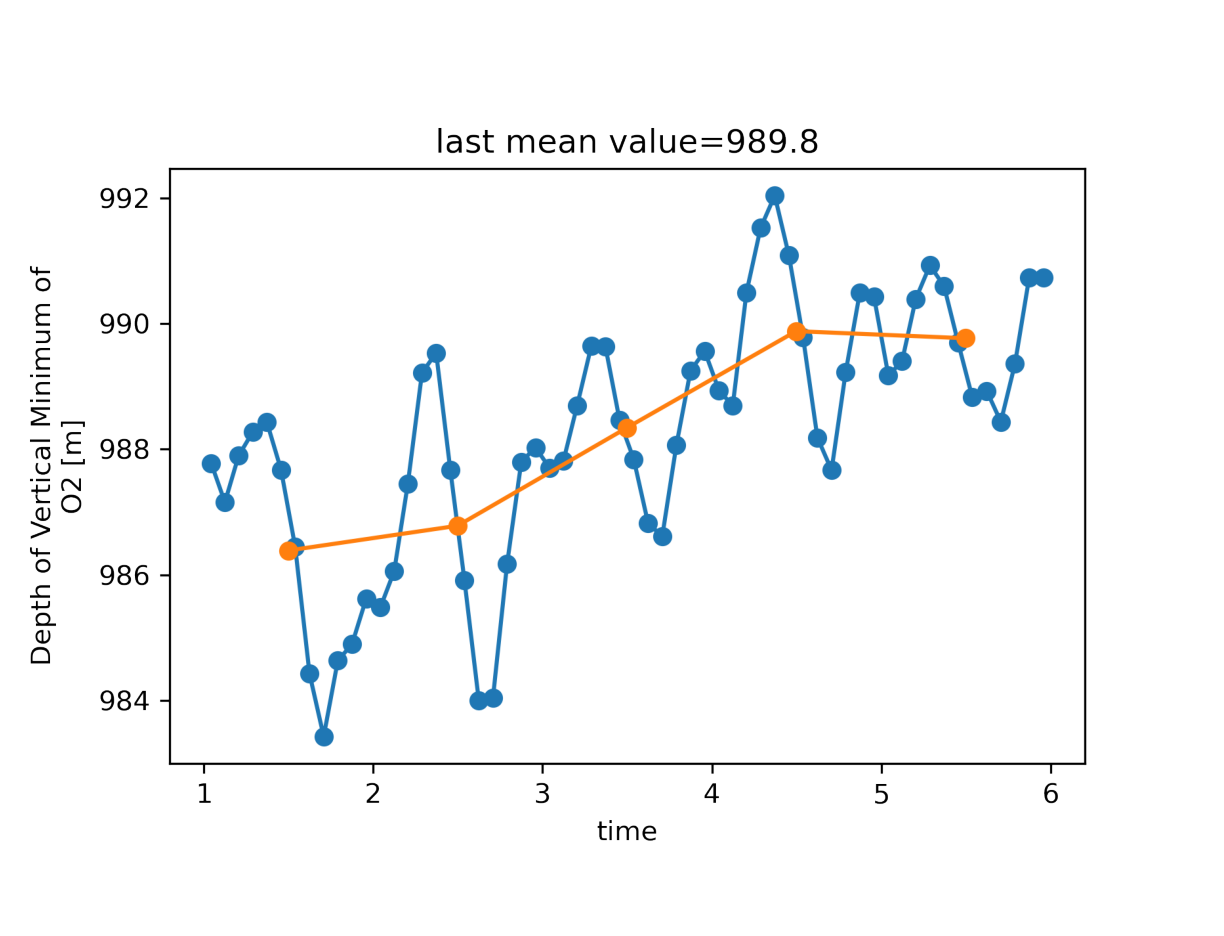
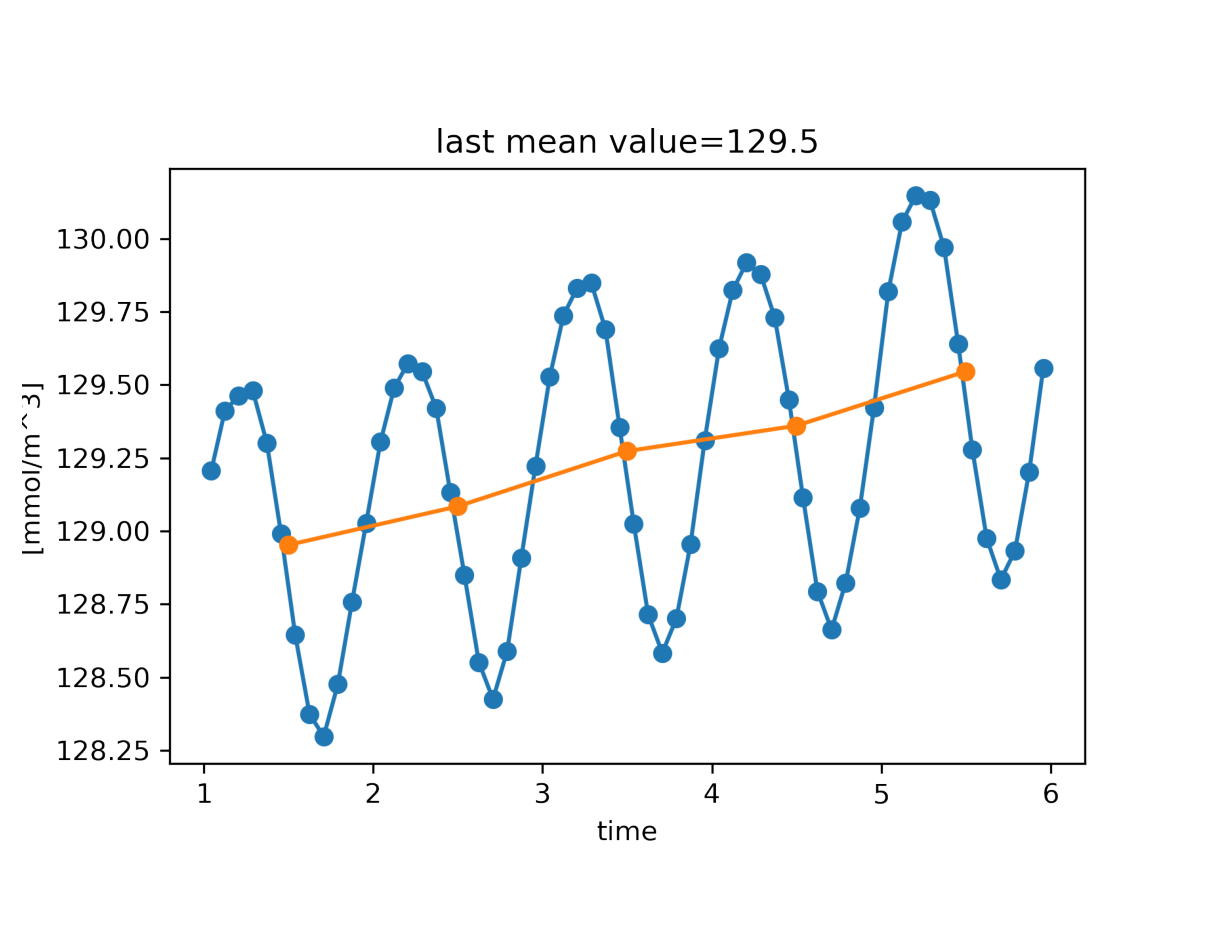

In [19]:
dashboard = pn.Tabs(
    ("Time Slice Maps", one_timestep_dashboard),
    ("Timeseries Plots", timeseries_dashboard),
)
dashboard.servable("HiRes-CESM Diagnostics Dashboard")